In [2]:
!pip install transformers datasets==2.14.0 accelerate fsspec==2023.9.2

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Fou

In [3]:
!pip install yfinance

In [1]:
# GPU 사용 가능 여부 확인
import torch
if torch.cuda.is_available():
    print(f'✓ GPU 사용 가능: {torch.cuda.get_device_name(0)}')
    print(f'GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
else:
    print('⚠ GPU를 사용할 수 없습니다. CPU로 진행합니다.')
    print('런타임 > 런타임 유형 변경 > GPU를 선택하세요.')

✓ GPU 사용 가능: Tesla T4
GPU 메모리: 15.83 GB


In [2]:
import torch
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from transformers import (PatchTSTConfig, PatchTSTForPrediction, Trainer, TrainingArguments, EarlyStoppingCallback)
from torch.utils.data import Dataset

### 주식 데이터 수집 및 전처리
Yahoo Finance에서 데이터 다운로드: Apple(AAPL) 주식의 최근 2년 데이터를 다운로드

원하는 종목으로 변경 가능 - 예: 'AAPL', 'GOOGL', 'MSFT', 'TSLA' 등

In [3]:
# 주식 종목 설정
ticker = 'AAPL'

# 데이터 기간 설정
end_date = datetime.now()
start_date = end_date - timedelta(days=3000)
print(f'주식 데이터 다운로드 중: {ticker}')
print(f'기간: {start_date.date()} ~ {end_date.date()}')

# 데이터 다운로드
stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
print(f'\n✓ 데이터 다운로드 완료!')
print(f'총 데이터 포인트: {len(stock_data)}개')

주식 데이터 다운로드 중: AAPL
기간: 2017-11-08 ~ 2026-01-25


/tmp/ipython-input-2089540540.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)



✓ 데이터 다운로드 완료!
총 데이터 포인트: 2062개


In [4]:
# 샘플 출력
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2017-11-08,41.126125,41.126125,40.680420,40.757427,97638000
2017-11-09,41.042122,41.093460,40.402733,40.862439,117930400
2017-11-10,40.906277,41.072554,40.812601,41.009322,100582000
2017-11-13,40.742355,40.866477,40.608864,40.632285,67928400
2017-11-14,40.126442,40.627613,40.088970,40.524567,99130000


In [ ]:
# 사용할 특징 선택 (OHLCV - Open, High, Low, Close, Volume)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = stock_data[features].copy()
# 결측치 제거
df = df.dropna()
print('=== 데이터 정보 ===')
print(f'사용 특징: {features}')
print(f'특징 개수: {len(features)}개')
print(f'데이터 크기: {df.shape}')
print(f'\n기초 통계:')
print(df.describe())

=== 데이터 정보 ===
사용 특징: ['Open', 'High', 'Low', 'Close', 'Volume']
특징 개수: 5개
데이터 크기: (2062, 5)

기초 통계:
Price          Open         High          Low        Close        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   2062.000000  2062.000000  2062.000000  2062.000000  2.062000e+03
mean     134.624267   136.103651   133.258175   134.743279  9.426715e+07
std       67.925674    68.581126    67.312465    67.973690  5.408752e+07
min       34.225167    34.638779    33.754506    33.799671  1.791060e+07
25%       61.821837    62.629185    61.004147    61.896566  5.562925e+07
50%      142.063572   143.968440   140.638155   142.426598  8.134545e+07
75%      183.213438   184.820072   181.548723   183.075199  1.145792e+08
max      286.200012   288.619995   283.299988   286.190002  4.265100e+08


### 데이터 정규화
기학습된 PatchTST의 입력이 정규화된 값이기 때문에 StandardScaler를 사용하여 정규화

In [6]:
# 데이터 정규화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.values)
print('✓ 데이터 정규화 완료')
print(f'정규화 후 데이터 형태: {scaled_data.shape}')
print(f'정규화 후 평균: {scaled_data.mean(axis=0)}')
print(f'정규화 후 표준편차: {scaled_data.std(axis=0)}')

✓ 데이터 정규화 완료
정규화 후 데이터 형태: (2062, 5)
정규화 후 평균: [ 0.00000000e+00  2.20537028e-16  0.00000000e+00 -5.51342569e-17
 -5.51342569e-17]
정규화 후 표준편차: [1. 1. 1. 1. 1.]


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Close'])
plt.xlabel("date")
plt.ylabel("price")
plt.show()

In [7]:
scaled_data = df.values

# 데이터 분할 비율 설정
train_ratio = 0.7 # 70% 학습
val_ratio = 0.15  # 15% 검증
test_ratio = 0.15 # 15% 테스트
# 분할 인덱스 계산
total_len = len(scaled_data)
train_end = int(total_len * train_ratio)
val_end = int(total_len * (train_ratio + val_ratio))

# 데이터 분할
train_data = scaled_data[:train_end]
val_data = scaled_data[train_end:val_end]
test_data = scaled_data[val_end:]
print('=== 데이터 분할 결과 ===')
print(f'전체 데이터: {total_len}개')
print(f'학습 데이터: {len(train_data)}개 ({len(train_data)/total_len*100:.1f}%)')
print(f'검증 데이터: {len(val_data)}개 ({len(val_data)/total_len*100:.1f}%)')
print(f'테스트 데이터: {len(test_data)}개 ({len(test_data)/total_len*100:.1f}%)')

=== 데이터 분할 결과 ===
전체 데이터: 2062개
학습 데이터: 1443개 (70.0%)
검증 데이터: 309개 (15.0%)
테스트 데이터: 310개 (15.0%)


In [8]:
class TimeSeriesDataset(Dataset):
  """
  시계열 데이터를 위한 PyTorch Dataset
  Parameters:
  -----------
  data : numpy.ndarray         정규화된 시계열 데이터 [timesteps, features]
  context_length : int         입력으로 사용할 과거 데이터 길이
  prediction_length : int      예측할 미래 데이터 길이
  """

  def __init__(self, data, context_length, prediction_length):
    self.data = data
    self.context_length = context_length
    self.prediction_length = prediction_length
    # 생성 가능한 샘플 수 계산
    self.total_length = context_length + prediction_length
    self.num_samples = len(data) - self.total_length + 1

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    # 시작 인덱스
    start_idx = idx
    sample_values = self.data[start_idx:start_idx + self.total_length]
    sample_mean = np.mean(sample_values, axis=0)
    sample_std = np.std(sample_values, axis=0)
    # 과거 데이터 (입력)
    past_values = self.data[start_idx:start_idx + self.context_length]
    # 샘플별 스케일링
    past_values_scaled = (past_values - sample_mean) / sample_std
    # 미래 데이터 (정답)
    future_values = self.data[
        start_idx + self.context_length:
        start_idx + self.total_length
    ]
    # 샘플별 스케일링
    future_values_scaled = (future_values - sample_mean) / sample_std
    return {
        'past_values': torch.tensor(past_values_scaled, dtype=torch.float32),
        'future_values': torch.tensor(future_values_scaled, dtype=torch.float32)
    }

In [9]:
# 시퀀스 길이 설정
context_length = 128
# 과거 128 타임스텝 사용
prediction_length = 24
# 24 타임스텝 예측 (약 1개월)
print('=== 하이퍼파라미터 ===')
print(f'입력 길이 (context_length): {context_length}')
print(f'예측 길이 (prediction_length): {prediction_length}')
print(f'특징 개수 (num_input_channels): {len(features)}')

=== 하이퍼파라미터 ===
입력 길이 (context_length): 128
예측 길이 (prediction_length): 24
특징 개수 (num_input_channels): 5


In [10]:
# 학습/검증/테스트 Dataset 생성
train_dataset = TimeSeriesDataset(
    train_data,
    context_length,
    prediction_length
)
val_dataset = TimeSeriesDataset(
    val_data,
    context_length,
    prediction_length
)
test_dataset = TimeSeriesDataset(
    test_data,
    context_length,
    prediction_length
)
print('=== Dataset 생성 완료 ===')
print(f'학습 샘플 수: {len(train_dataset)}')
print(f'검증 샘플 수: {len(val_dataset)}')
print(f'테스트 샘플 수: {len(test_dataset)}')

# 샘플 데이터 확인
sample = train_dataset[0]
print(f'\n샘플 데이터 형태:')
print(f'  past_values: {sample["past_values"].shape}')      # [context_length, features]
print(f'  future_values: {sample["future_values"].shape}')  # [prediction_length, features]

=== Dataset 생성 완료 ===
학습 샘플 수: 1292
검증 샘플 수: 158
테스트 샘플 수: 159

샘플 데이터 형태:
  past_values: torch.Size([128, 5])
  future_values: torch.Size([24, 5])


### ibm-granite/granite-timeseries-patchtst vs ibm/patchtst-etth1-forecasting

Based on the search results, ibm-granite/granite-timeseries-patchtst and ibm/patchtst-etth1-forecasting refer to the same foundational model, with the latter often being an alias or a more specific identifier for the pre-trained version of the PatchTST model on the ETTh1 dataset.

**Differences in Context**
- ibm-granite/granite-timeseries-patchtst: This is identified as a model within the IBM Granite Time Series collection, designed for flexible, multi-tasking (forecasting, classification) and easy fine-tuning. It is frequently highlighted in the granite-tsfm (Time Series Foundation Model) library.
- ibm/patchtst-etth1-forecasting: This identifier points specifically to the pre-trained weights intended for the task of forecasting on the ETTh1 dataset, often used as a direct benchmark.

### 모델 설정 조정
💡 중요: 사전학습 모델의 설정을 주식 데이터에 맞게 조정합니다. 특히 입력 채널 수, context_length, prediction_length를 변경합니다.


In [11]:
# 사전학습 모델 이름
pretrained_model = "ibm-granite/granite-timeseries-patchtst"
print(f'사전학습 모델 로드 중: {pretrained_model}')

# 사전학습 모델의 config를 로드하고 우리 데이터에 맞게 수정
config = PatchTSTConfig.from_pretrained(pretrained_model)
config.num_input_channels = len(features)    # 5개 (OHLCV)
config.context_length = context_length       # 128
config.prediction_length = prediction_length # 24

# 수정된 config로 모델 생성 (사전학습 가중치 중 호환되는 부분만 로드)
model = PatchTSTForPrediction.from_pretrained(
    pretrained_model,
    config=config,
    ignore_mismatched_sizes=True  # 크기가 다른 레이어는 새로 초기화
)

print('✓ 사전학습 모델 로드 완료')
print(f'모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}개')

사전학습 모델 로드 중: ibm-granite/granite-timeseries-patchtst


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of PatchTSTForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-patchtst and are newly initialized because the shapes did not match:
- head.projection.bias: found shape torch.Size([96]) in the checkpoint and torch.Size([24]) in the model instantiated
- head.projection.weight: found shape torch.Size([96, 128]) in the checkpoint and torch.Size([24, 128]) in the model instantiated
- model.encoder.positional_encoder.position_en

✓ 사전학습 모델 로드 완료
모델 파라미터 수: 601,112개


In [12]:
print('=== 업데이트된 모델 설정 ===')
print(f'입력 채널 수: {model.config.num_input_channels}')
print(f'Context 길이: {model.config.context_length}')
print(f'예측 길이: {model.config.prediction_length}')
print(f'패치 길이: {model.config.patch_length}')
print(f'패치 간격: {model.config.patch_stride}')
print(f'히든 차원: {model.config.d_model}')
print(f'레이어 수: {model.config.num_hidden_layers}')

=== 업데이트된 모델 설정 ===
입력 채널 수: 5
Context 길이: 128
예측 길이: 24
패치 길이: 12
패치 간격: 12
히든 차원: 128
레이어 수: 3


In [13]:
# GPU 사용 가능하면 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# 학습 하이퍼파라미터 설정
training_args = TrainingArguments(
    output_dir='./patchtst_stock_finetuned',    # 모델 저장 경로

    # 학습 설정
    num_train_epochs=200,               # 에포크 수
    per_device_train_batch_size=32,    # 배치 크기
    per_device_eval_batch_size=64,     # 평가 배치 크기

    # 학습률 및 옵티마이저
    learning_rate=1e-4,                # 학습률 (fine-tuning은 작게 설정)
    warmup_steps=50,                   # 워밍업 스텝
    weight_decay=0.01,                 # 가중치 감쇠 (과적합 방지)

    # 평가 및 저장
    eval_strategy='epoch',             # 에포크마다 평가
    save_strategy='epoch',             # 에포크마다 저장
    save_total_limit=3,                # 최근 3개 체크포인트만 유지

    # 로깅
    logging_dir='./logs',
    logging_strategy='epoch',
    logging_steps=10,

    # 성능 최적화
    fp16=torch.cuda.is_available(),    # GPU 있으면 mixed precision 사용
    dataloader_num_workers=2,          # 재현성
    seed=42,
)

In [ ]:
# Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [79]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss
1,0.085000,No log
2,0.092700,No log
3,0.097300,No log
4,0.095800,No log
5,0.095300,No log
6,0.095600,No log
7,0.095200,No log
8,0.094600,No log
9,0.094300,No log
10,0.093600,No log


In [18]:
# 모델 저장
trainer.save_model('./patchtst_stock_final')
print('\n✓ Fine-tuned 모델 저장 완료: ./patchtst_stock_final')


✓ Fine-tuned 모델 저장 완료: ./patchtst_stock_final


In [19]:
# 테스트 데이터로 평가
test_results = trainer.evaluate(test_dataset)
print('=== 테스트 결과 ===')
print(f'테스트 손실 (MSE): {test_results["loss"]:.6f}')

=== 테스트 결과 ===


KeyError: 'loss'

### 샘플 테스트 데이터 예측 및 시각화

In [74]:
# 예측 모드로 설정
model.eval()

# 테스트 샘플 선택
test_sample_idx = 0 # 100
test_sample = test_dataset[test_sample_idx]
# 예측 수행
with torch.no_grad():
    past_values = test_sample['past_values'].unsqueeze(0).to(device)  # [1, features, time]
    outputs = model(past_values=past_values)
    predictions = outputs.prediction_outputs[0]  # [time, features]

    # CPU로 이동 및 numpy 변환
    predictions = predictions.cpu().numpy()
    true_values = test_sample['future_values'].numpy()  # [time, features]
    print('✓ 예측 완료')
    print(f'예측 결과 형태: {predictions.shape}')
    print(f'실제 값 형태: {true_values.shape}')

✓ 예측 완료
예측 결과 형태: (24, 5)
실제 값 형태: (24, 5)


In [22]:
outputs.prediction_outputs.shape

torch.Size([1, 24, 5])

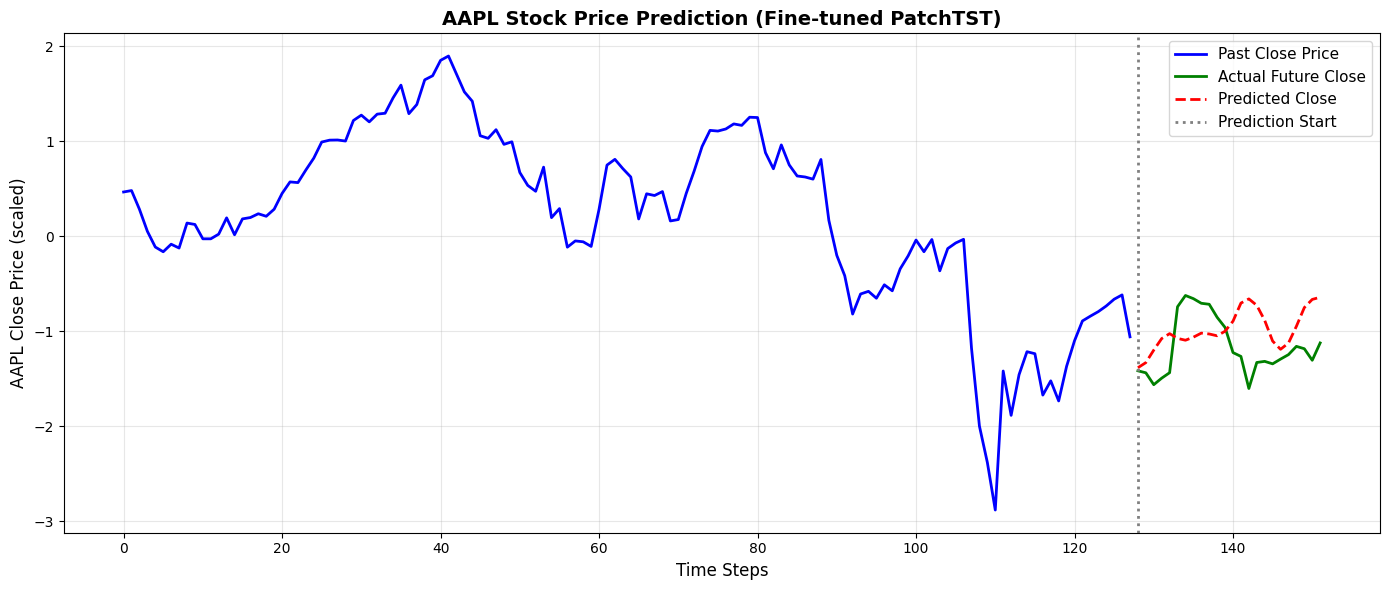

In [76]:
# 종가 예측 시각화
close_idx = features.index('Close')  # Close 컬럼의 인덱스 (3)
plt.figure(figsize=(14, 6))

# 과거 데이터 (context)
past_close = test_sample['past_values'][:, close_idx].cpu().numpy()
#past_close_orig = inverse_transform(scaler.mean_ + past_close * scaler.scale_, scaler)[close_idx]
time_steps_past = range(len(past_close))
time_steps_future = range(len(past_close), len(past_close) + prediction_length)

# 그래프 그리기
plt.plot(time_steps_past, past_close, label='Past Close Price', color='blue', linewidth=2)
plt.plot(time_steps_future, true_values[:, close_idx], label='Actual Future Close', color='green', linewidth=2)
plt.plot(time_steps_future, predictions[:, close_idx], label='Predicted Close', color='red', linewidth=2, linestyle='--')

# 경계선
plt.axvline(x=len(past_close), color='gray', linestyle=':', linewidth=2, label='Prediction Start')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel(f'{ticker} Close Price (scaled)', fontsize=12)
plt.title(f'{ticker} Stock Price Prediction (Fine-tuned PatchTST)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [117]:
def predict_and_show(test_sample_idx, png_filename=None):
  # 예측 모드로 설정
  model.eval()

  # 테스트 샘플 선택
  test_sample = test_dataset[test_sample_idx]

  # 예측 수행
  with torch.no_grad():
    past_values = test_sample['past_values'].unsqueeze(0).to(device)  # [1, features, time]
    outputs = model(past_values=past_values)
    predictions = outputs.prediction_outputs[0]  # [time, features]

    # CPU로 이동 및 numpy 변환
    predictions = predictions.cpu().numpy()
    true_values = test_sample['future_values'].numpy()  # [time, features]

  # 종가 예측 시각화
  close_idx = features.index('Close')  # Close 컬럼의 인덱스 (3)
  plt.figure(figsize=(14, 6))

  # 과거 데이터 (context)
  past_close = test_sample['past_values'][:, close_idx].cpu().numpy()
  #past_close_orig = inverse_transform(scaler.mean_ + past_close * scaler.scale_, scaler)[close_idx]
  time_steps_past = range(len(past_close))
  time_steps_future = range(len(past_close), len(past_close) + prediction_length)

  # 그래프 그리기
  plt.plot(time_steps_past, past_close, label='Past Close Price', color='blue', linewidth=2)
  plt.plot(time_steps_future, true_values[:, close_idx], label='Actual Future Close', color='green', linewidth=2)
  plt.plot(time_steps_future, predictions[:, close_idx], label='Predicted Close', color='red', linewidth=2, linestyle='--')

  # 경계선
  plt.axvline(x=len(past_close), color='gray', linestyle=':', linewidth=2, label='Prediction Start')
  plt.xlabel('Time Steps', fontsize=12)
  plt.ylabel(f'{ticker} Close Price (scaled)', fontsize=12)
  plt.title(f'{ticker} Stock Price Prediction (Fine-tuned PatchTST)', fontsize=14, fontweight='bold')
  plt.legend(fontsize=11)
  plt.grid(True, alpha=0.3)
  plt.tight_layout()

  if png_filename is not None:
    plt.savefig(png_filename, dpi=150, bbox_inches='tight')
  else:
    plt.show()
  plt.close()

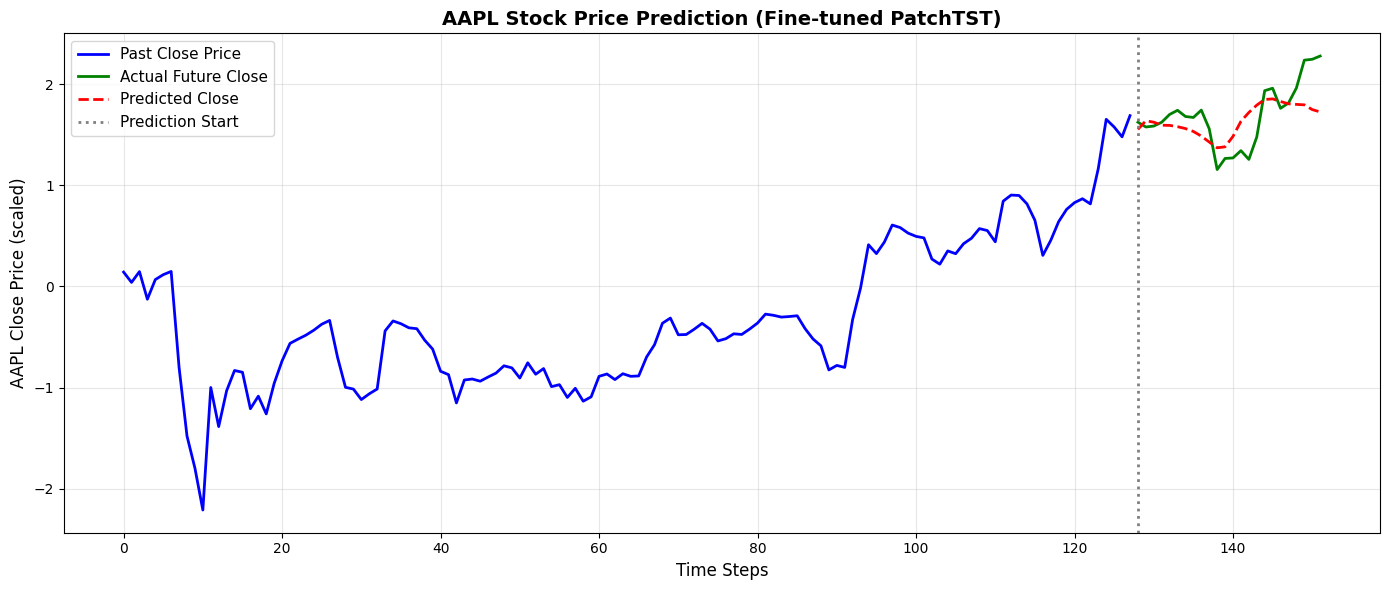

In [78]:
predict_and_show(100)

위는 에폭 400회, training loss = 0.88 수준에서의 결과, 아래는 에폭 600회 tranining loss = 0.61

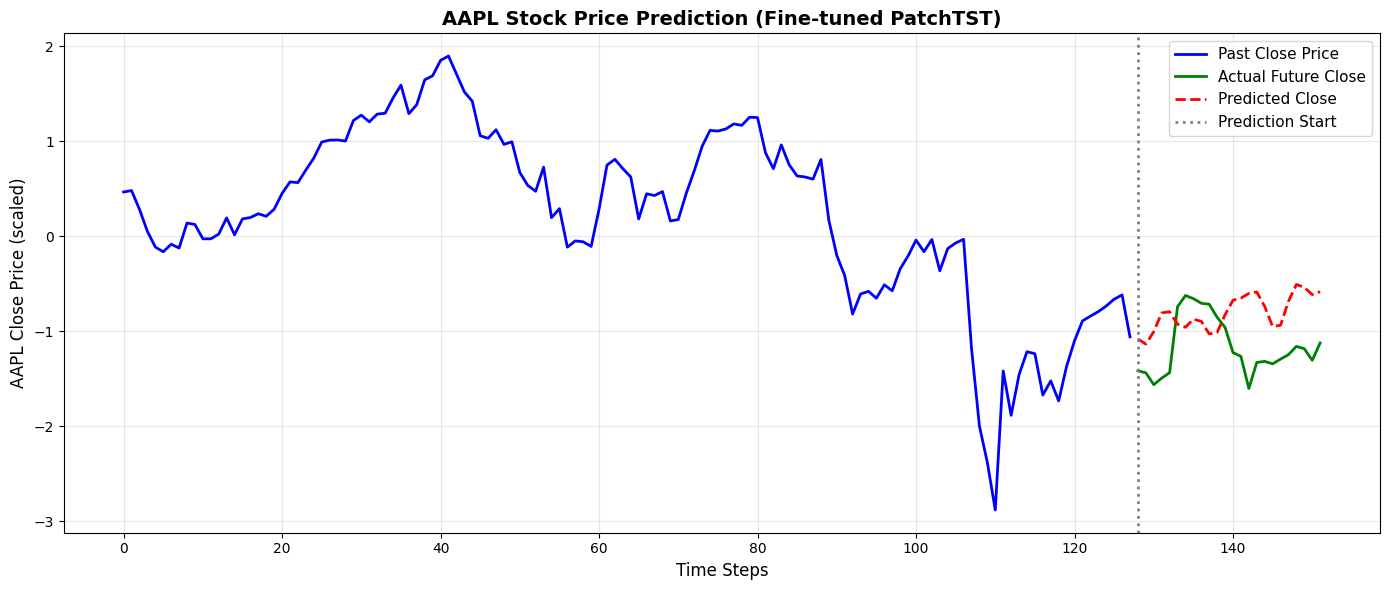

In [80]:
predict_and_show(0)

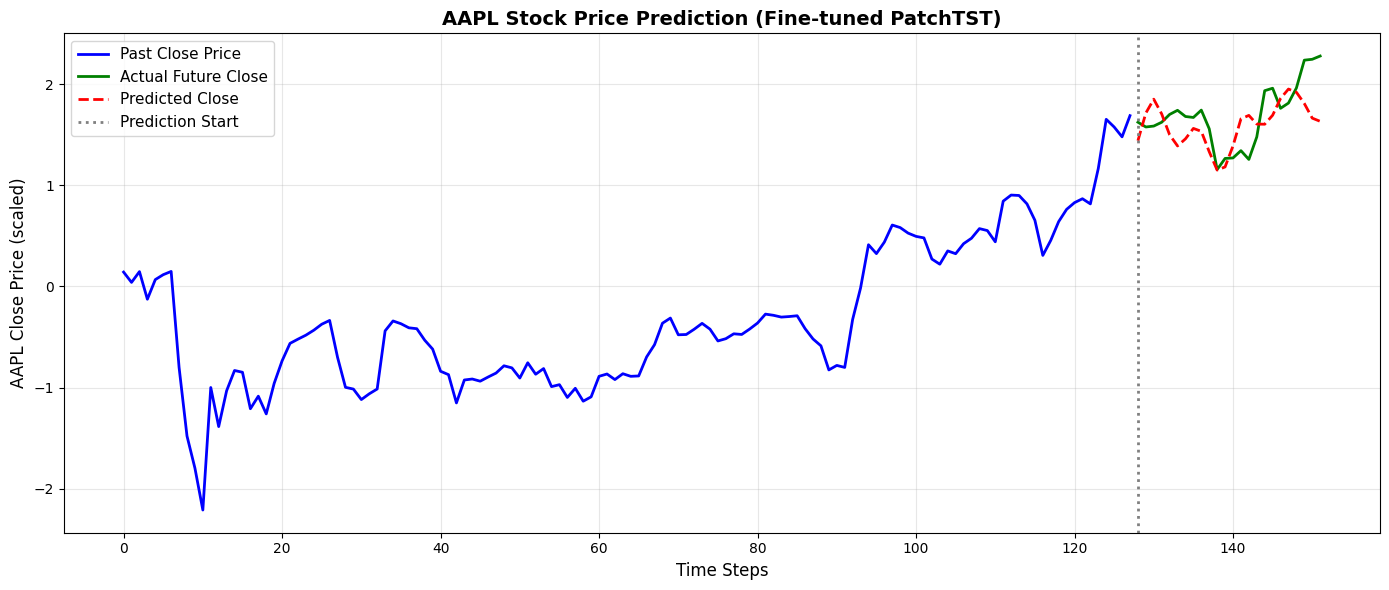

In [119]:
predict_and_show(100)

In [109]:
!ls

logs		      patchtst_stock_finetuned	sample_data
patchtst_stock_final  png_filename.png		wandb


In [120]:
import glob
import imageio.v2 as imageio

def predict_and_animate(start_idx, finish_idx):
  for i in range(start_idx, finish_idx):
    predict_and_show(i, f"predict_{i:05}.png")
    print(f"predict_{i:05}.png ...")

  anim_file = f"predict_{ticker}.gif"

  with imageio.get_writer(anim_file, mode='I') as writer:
      filenames = glob.glob('predict_*.png')
      filenames = sorted(filenames)
      for filename in filenames:
          image = imageio.imread(filename)
          writer.append_data(image)
      image = imageio.imread(filename)
      writer.append_data(image)

In [121]:
predict_and_animate(0, 159)

predict_00000.png ...
predict_00001.png ...
predict_00002.png ...
predict_00003.png ...
predict_00004.png ...
predict_00005.png ...
predict_00006.png ...
predict_00007.png ...
predict_00008.png ...
predict_00009.png ...
predict_00010.png ...
predict_00011.png ...
predict_00012.png ...
predict_00013.png ...
predict_00014.png ...
predict_00015.png ...
predict_00016.png ...
predict_00017.png ...
predict_00018.png ...
predict_00019.png ...
predict_00020.png ...
predict_00021.png ...
predict_00022.png ...
predict_00023.png ...
predict_00024.png ...
predict_00025.png ...
predict_00026.png ...
predict_00027.png ...
predict_00028.png ...
predict_00029.png ...
predict_00030.png ...
predict_00031.png ...
predict_00032.png ...
predict_00033.png ...
predict_00034.png ...
predict_00035.png ...
predict_00036.png ...
predict_00037.png ...
predict_00038.png ...
predict_00039.png ...
predict_00040.png ...
predict_00041.png ...
predict_00042.png ...
predict_00043.png ...
predict_00044.png ...
predict_00

predict_00000.png
predict_00001.png
predict_00002.png
predict_00003.png
predict_00004.png
predict_00005.png
predict_00006.png
predict_00007.png
predict_00008.png
predict_00009.png
predict_00010.png
predict_00011.png
predict_00012.png
predict_00013.png
predict_00014.png
predict_00015.png
predict_00016.png
predict_00017.png
predict_00018.png
predict_00019.png
predict_00020.png
predict_00021.png
predict_00022.png
predict_00023.png
predict_00024.png
predict_00025.png
predict_00026.png
predict_00027.png
predict_00028.png
predict_00029.png
predict_00030.png
predict_00031.png
predict_00032.png
predict_00033.png
predict_00034.png
predict_00035.png
predict_00036.png
predict_00037.png
predict_00038.png
predict_00039.png
predict_00040.png
predict_00041.png
predict_00042.png
predict_00043.png
predict_00044.png
predict_00045.png
predict_00046.png
predict_00047.png
predict_00048.png
predict_00049.png
predict_00050.png
predict_00051.png
predict_00052.png
predict_00053.png
predict_00054.png
predict_00

In [128]:
from google.colab import files
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>